# Deep learning the collisional cross sections of the peptide universe from a million experimental values

Florian Meier, Niklas D. Köhler, Andreas-David Brunner, Jean-Marc H. Wanka, Eugenia Voytik, Maximilian T. Strauss, Fabian J. Theis, Matthias Mann

Pre-print: https://doi.org/10.1101/2020.05.19.102285  
Publication: pending

revised 09/2020

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

from numba import njit, prange
import time

from scipy import stats
import scipy.cluster.hierarchy as shc
import scipy.spatial.distance as ssd

In [2]:
@njit
def mean_dist_pairwise(matrix, shape):
    dist = np.zeros((shape,shape))
    
    for i in prange(shape):
        for j in prange(shape):
            dist[j,i] = np.nanmean(matrix[:,i] - matrix[:,j])
    
    return dist  

#### Import raw data from MaxQuant output

In [3]:
# Load evidence.txt files from folder
filenames = glob.glob("data/evidence_MQ/*.txt")
evidences = [pd.read_csv(filename, sep='\t', engine='python', header=0) for filename in filenames]

# Combine all evidences in one dataframe
evidence_all = pd.concat(evidences, sort=False, ignore_index=True)

# Clean up 
del evidences

evidence_all.head()

,Sequence,Length,Modifications,Modified sequence,Oxidation (M) Probabilities,Oxidation (M) Score Diffs,Oxidation (M),Missed cleavages,Proteins,Leading proteins,...,GlyGly (K),GlyGly (K) site IDs,Hydroxyproline Probabilities,Hydroxyproline Score Diffs,Hydroxyproline,Hydroxyproline site IDs,Crotonyl Probabilities,Crotonyl Score Diffs,Crotonyl,Crotonyl site IDs
0,ADVTPADFSEWSK,13,Unmodified,_ADVTPADFSEWSK_,NaN,NaN,0,0.0,Biognosys|iRT-Kit_WR_fusion,Biognosys|iRT-Kit_WR_fusion,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ADVTPADFSEWSK,13,Unmodified,_ADVTPADFSEWSK_,NaN,NaN,0,0.0,Biognosys|iRT-Kit_WR_fusion,Biognosys|iRT-Kit_WR_fusion,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ADVTPADFSEWSK,13,Unmodified,_ADVTPADFSEWSK_,NaN,NaN,0,0.0,Biognosys|iRT-Kit_WR_fusion,Biognosys|iRT-Kit_WR_fusion,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ADVTPADFSEWSK,13,Unmodified,_ADVTPADFSEWSK_,NaN,NaN,0,0.0,Biognosys|iRT-Kit_WR_fusion,Biognosys|iRT-Kit_WR_fusion,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ADVTPADFSEWSK,13,Unmodified,_ADVTPADFSEWSK_,NaN,NaN,0,0.0,Biognosys|iRT-Kit_WR_fusion,Biognosys|iRT-Kit_WR_fusion,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Drop reverse hits
# Drop features with no intensity value
# Drop charge 1 features

evidence_all = evidence_all.loc[(evidence_all['Reverse'] != '+') & \
                                (evidence_all['Intensity'] > 0) & \
                                (evidence_all['Charge'] != 1)]
len(evidence_all)

15230708

In [5]:
# Keep only one evidence per raw file
# Select feature with maximum intensity

selection = ['Modified sequence', 'Sequence', 'Charge', 'Mass', 'm/z', 'CCS', 'Experiment', 
             'id', 'Intensity', 'Score', 'Length', 'Raw file']
evidence_agg = evidence_all.loc[evidence_all.groupby(
    ['Modified sequence', 'Charge', 'Raw file'])['Intensity'].idxmax()][selection]
len(evidence_agg)


10379873

In [6]:

evidence_pivot_long = evidence_agg.pivot_table(index = ['Modified sequence', 'Charge'], 
                                               columns = 'Raw file', 
                                               values = 'CCS')
del evidence_agg

evidence_pivot_long = evidence_pivot_long.astype(np.float32)

len(evidence_pivot_long)

1148760

In [7]:
evidence_pivot_long.head()

Raw file                                                   10_210519_201201C_Martell_Set1_C3-_S2-B10_1_2384  \
Modified sequence                                  Charge                                                     
_(Acetyl (Protein N-term))AAAAAAAAAAGAAGGR_        2                                              412.97937   
_(Acetyl (Protein N-term))AAAAAAAAAAGDSDSWDADTF... 3                                                    NaN   
_(Acetyl (Protein N-term))AAAAAAAAAAGDSDSWDADTF... 2                                                    NaN   
                                                   3                                                    NaN   
_(Acetyl (Protein N-term))AAAAAAAAAAM(Oxidation... 2                                                    NaN   

Raw file                                                   10_RD2_1_1705  \
Modified sequence                                  Charge                  
_(Acetyl (Protein N-term))AAAAAAAAAAGAAGGR_        2                 NaN   
_(Acetyl (Protein N-term))AAAAAAAAAAGDSDSWDADTF... 3                 NaN   
_(Acetyl (Protein N-term))AAAAAAAAAAGDSDSWDADTF... 2                 NaN   
                                                   3                 NaN   
_(Acetyl (Protein N-term))AAAAAAAAAAM(Oxidation... 2                 NaN   

Raw file                                                   11_210519_201201C_Martell_Set1_BDL4+_S2-B11_1_2385  \
Modified sequence                                  Charge                                                       
_(Acetyl (Protein N-term))AAAAAAAAAAGAAGGR_        2                                                     NaN    
_(Acetyl (Protein N-term))AAAAAAAAAAGDSDSWDADTF... 3                                                     NaN    
_(Acetyl (Protein N-term))AAAAAAAAAAGDSDSWDADTF... 2                                                     NaN    
                                                   3                                                     NaN    
_(Acetyl (Protein N-term))AAAAAAAAAAM(Oxidation... 2                                                     NaN    

Raw file                                                   11_RD3_1_1706  \
Modified sequence                                  Charge                  
_(Acetyl (Protein N-term))AAAAAAAAAAGAAGGR_        2                 NaN   
_(Acetyl (Protein N-term))AAAAAAAAAAGDSDSWDADTF... 3                 NaN   
_(Acetyl (Protein N-term))AAAAAAAAAAGDSDSWDADTF... 2                 NaN   
                                                   3                 NaN   
_(Acetyl (Protein N-term))AAAAAAAAAAM(Oxidation... 2                 NaN   

Raw file                                                   12_210519_201201C_Martell_Set1_C6-_S2-B12_1_2386  \
Modified sequence                                  Charge                                                     
_(Acetyl (Protein N-term))AAAAAAAAAAGAAGGR_        2                                                    NaN   
_(Acetyl (Protein N-term))AAAAAAAAAAGDSDSWDADTF... 3                                                    NaN   
_(Acetyl (Protein N-term))AAAAAAAAAAGDSDSWDADTF... 2                                                    NaN   
                                                   3                                                    NaN   
_(Acetyl (Protein N-term))AAAAAAAAAAM(Oxidation... 2                                                    NaN   

Raw file                                                   12_RD4_1_1707  \
Modified sequence                                  Charge                  
_(Acetyl (Protein N-term))AAAAAAAAAAGAAGGR_        2                 NaN   
_(Acetyl (Protein N-term))AAAAAAAAAAGDSDSWDADTF... 3                 NaN   
_(Acetyl (Protein N-term))AAAAAAAAAAGDSDSWDADTF... 2                 NaN   
                                                   3                 NaN   
_(Acetyl (Protein N-term))AAAAAAAAAAM(Oxidation... 2                 NaN   

Raw file                                             

In [8]:
# Filter peptides with only one occurence to speed up and save memory 
evidence_pivot = evidence_pivot_long.loc[evidence_pivot_long.isnull().sum(axis=1) < (len(set(evidence_all['Raw file'])) - 1)]
evidence_pivot = evidence_pivot.astype(np.float32)

len(evidence_pivot_long), len(evidence_pivot)

(1148760, 728050)

#### Align CCS values

In [ ]:
# calculate pair-wise distances

start = time.time()
evidence_distance = pd.DataFrame(mean_dist_pairwise(np.array(evidence_pivot), evidence_pivot.shape[1]))
end = time.time()

print((end - start)/60)

In [ ]:
evidence_distance.shape

(1504, 1504)

In [ ]:
# Fill NA distances with arbitrary large number
evidence_distance_cluster = evidence_distance.fillna(3*evidence_distance.max().max())
evidence_distance_cluster.min().min(), evidence_distance_cluster.max().max()

(-171.71859741210938, 515.1557922363281)

In [ ]:
# save result matrix
evidence_distance.to_csv('evidence_distance_float32_6.csv', index=False)
print('File exported.')

File exported.


In [ ]:
# load result matrix
evidence_distance = pd.read_csv('evidence_distance_float32_6.csv')

In [ ]:
dist_matrix = ssd.squareform(evidence_distance_cluster, checks=False)
dist_matrix

array([ 1.18487218,  1.37247363,  0.73267463, ..., -1.33232221,
       -0.58659939,  0.7757977 ])

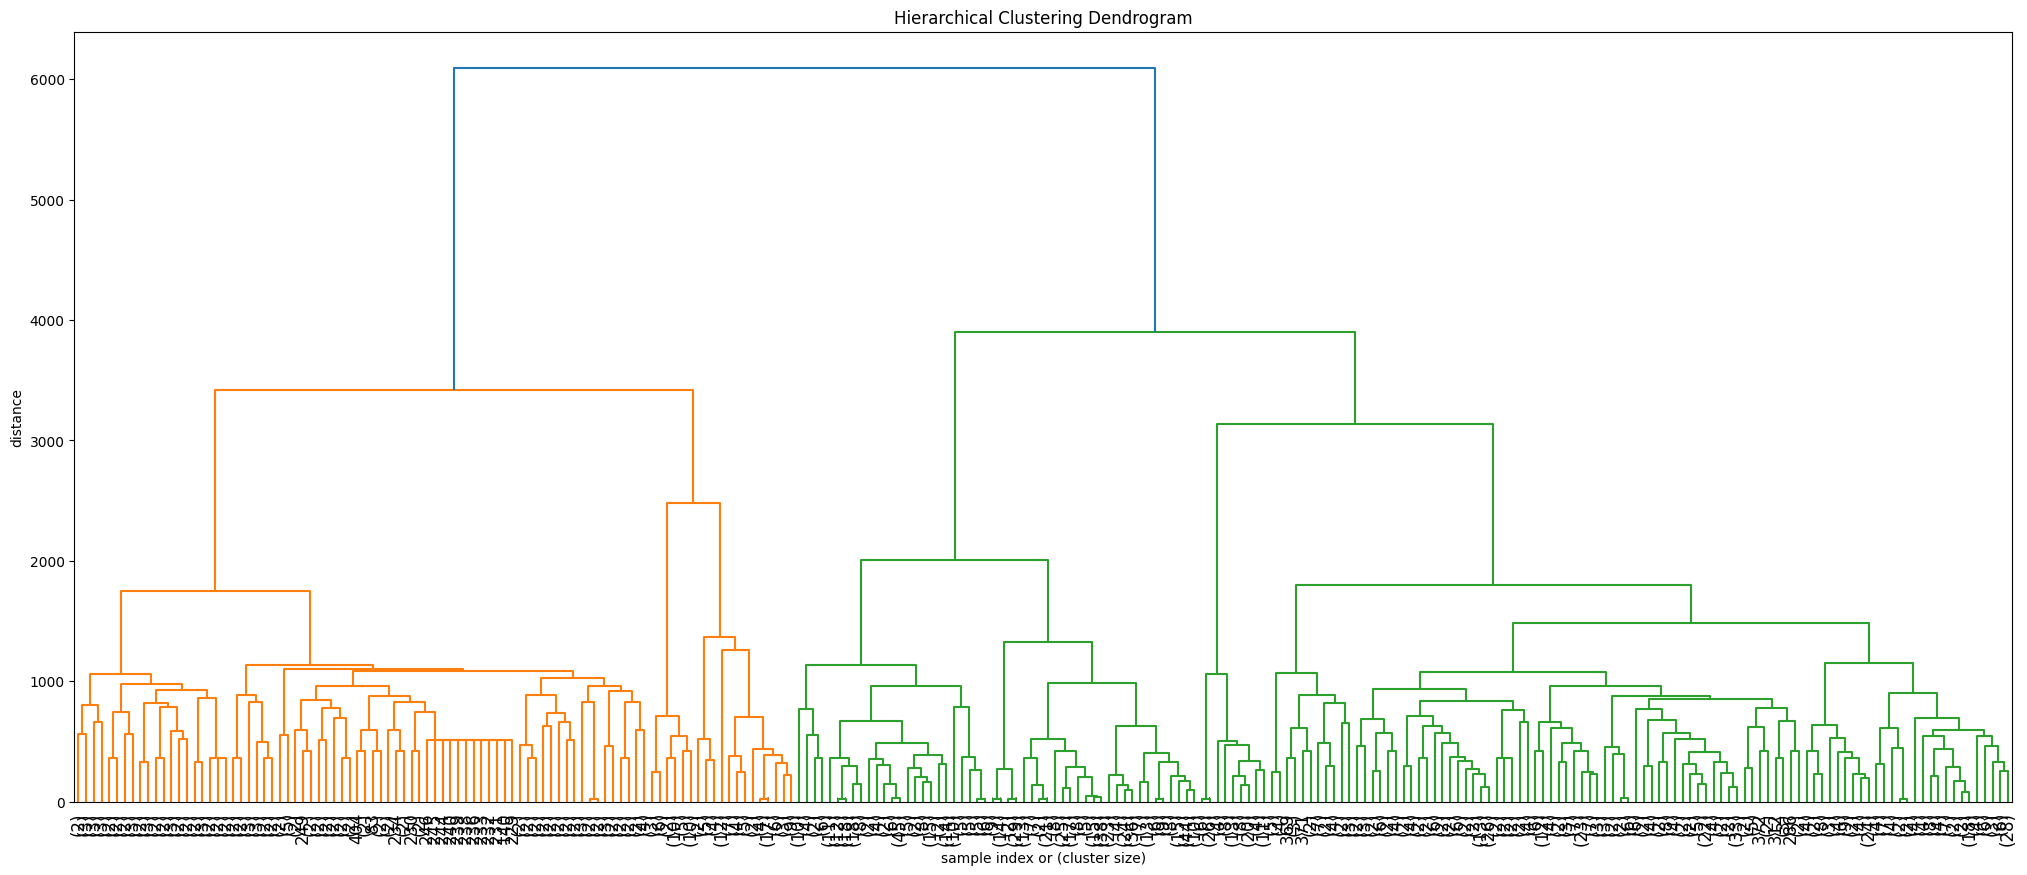

In [42]:
# Perform hierarchical clustering to sort runs by distance

Z = shc.linkage(abs(dist_matrix), 'ward')
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')

shc.dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=250,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)

plt.show()

In [43]:
nruns = len(evidence_pivot_long.columns) 

In [44]:
col = nruns
nancount = 0

for cluster in Z:
    # loop through clusters and merge them pairwise      
    
    # align first
    delta = np.nanmean(evidence_pivot_long.iloc[:, int(cluster[1])] - evidence_pivot_long.iloc[:, int(cluster[0])])   
    
    if(~np.isnan(delta)):
        # Merge neighboring runs 
        # Calculate mean

        evidence_pivot_long[col] = np.nanmean([evidence_pivot_long.iloc[:, int(cluster[1])] - 0.5*delta, 
                                               evidence_pivot_long.iloc[:, int(cluster[0])] + 0.5*delta], axis = 0)
    else:
        # NaN difference in a cluster to be merged   
        # Merge runs but keep external calibration
        
        evidence_pivot_long[col] = np.nanmean([evidence_pivot_long.iloc[:, int(cluster[1])], 
                                               evidence_pivot_long.iloc[:, int(cluster[0])]], axis = 0)

        
    col += 1
    
print('Clusters merged.')

/tmp/ipykernel_157478/2557891589.py:14: RuntimeWarning: Mean of empty slice
  evidence_pivot_long[col] = np.nanmean([evidence_pivot_long.iloc[:, int(cluster[1])] - 0.5*delta,
/tmp/ipykernel_157478/2557891589.py:14: RuntimeWarning: Mean of empty slice
  evidence_pivot_long[col] = np.nanmean([evidence_pivot_long.iloc[:, int(cluster[1])] - 0.5*delta,
/tmp/ipykernel_157478/2557891589.py:14: RuntimeWarning: Mean of empty slice
  evidence_pivot_long[col] = np.nanmean([evidence_pivot_long.iloc[:, int(cluster[1])] - 0.5*delta,
/tmp/ipykernel_157478/2557891589.py:14: RuntimeWarning: Mean of empty slice
  evidence_pivot_long[col] = np.nanmean([evidence_pivot_long.iloc[:, int(cluster[1])] - 0.5*delta,
/tmp/ipykernel_157478/2557891589.py:14: RuntimeWarning: Mean of empty slice
  evidence_pivot_long[col] = np.nanmean([evidence_pivot_long.iloc[:, int(cluster[1])] - 0.5*delta,
/tmp/ipykernel_157478/2557891589.py:14: RuntimeWarning: Mean of empty slice
  evidence_pivot_long[col] = np.nanmean([evidence

Clusters merged.


/tmp/ipykernel_157478/2557891589.py:14: RuntimeWarning: Mean of empty slice
  evidence_pivot_long[col] = np.nanmean([evidence_pivot_long.iloc[:, int(cluster[1])] - 0.5*delta,
/tmp/ipykernel_157478/2557891589.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  evidence_pivot_long[col] = np.nanmean([evidence_pivot_long.iloc[:, int(cluster[1])] - 0.5*delta,
/tmp/ipykernel_157478/2557891589.py:14: RuntimeWarning: Mean of empty slice
  evidence_pivot_long[col] = np.nanmean([evidence_pivot_long.iloc[:, int(cluster[1])] - 0.5*delta,
/tmp/ipykernel_157478/2557891589.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.c

In [45]:
# Store experimental values in separate dataframe
evidence_pivot_tmp = evidence_pivot_long.copy()
evidence_pivot_long = evidence_pivot_long.iloc[:, 0:nruns]

len(evidence_pivot_tmp.columns), len(evidence_pivot_long.columns)

(3007, 1504)

(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.,
        1600.]),
 [Text(-200.0, 0, '221006_JaKH_nE_DDA_PD2_n1-3_RVxF_3_6194'),
  Text(0.0, 0, '10_210519_201201C_Martell_Set1_C3-_S2-B10_1_2384'),
  Text(200.0, 0, '20181127_TIMS2_AnBr_SA_BestInPlace_Proteotypic_F6_F6_01_3597'),
  Text(400.0, 0, '20181213_TIMS2_AnBr_SA_BestInPlace_Proteotypic_Plate2_B8_B8_01_3826'),
  Text(600.0, 0, '20190227_TIMS2_FlMe_SA_200ng_Yeast_Trypsin_IRT_Fraction_12_D5_01_4224'),
  Text(800.0, 0, '20220405_AnWi_21PTM_E1_2_Slot1-29_1_2258'),
  Text(1000.0, 0, '210312_PS_CB_IP_empty_pcDNA_2_Slot1-19_1_1757'),
  Text(1200.0, 0, '22-Prot-1387_RC5_1_10892'),
  Text(1400.0, 0, 'AE155LQ_E4_Slot1-26_1_10770'),
  Text(1600.0, 0, '')])

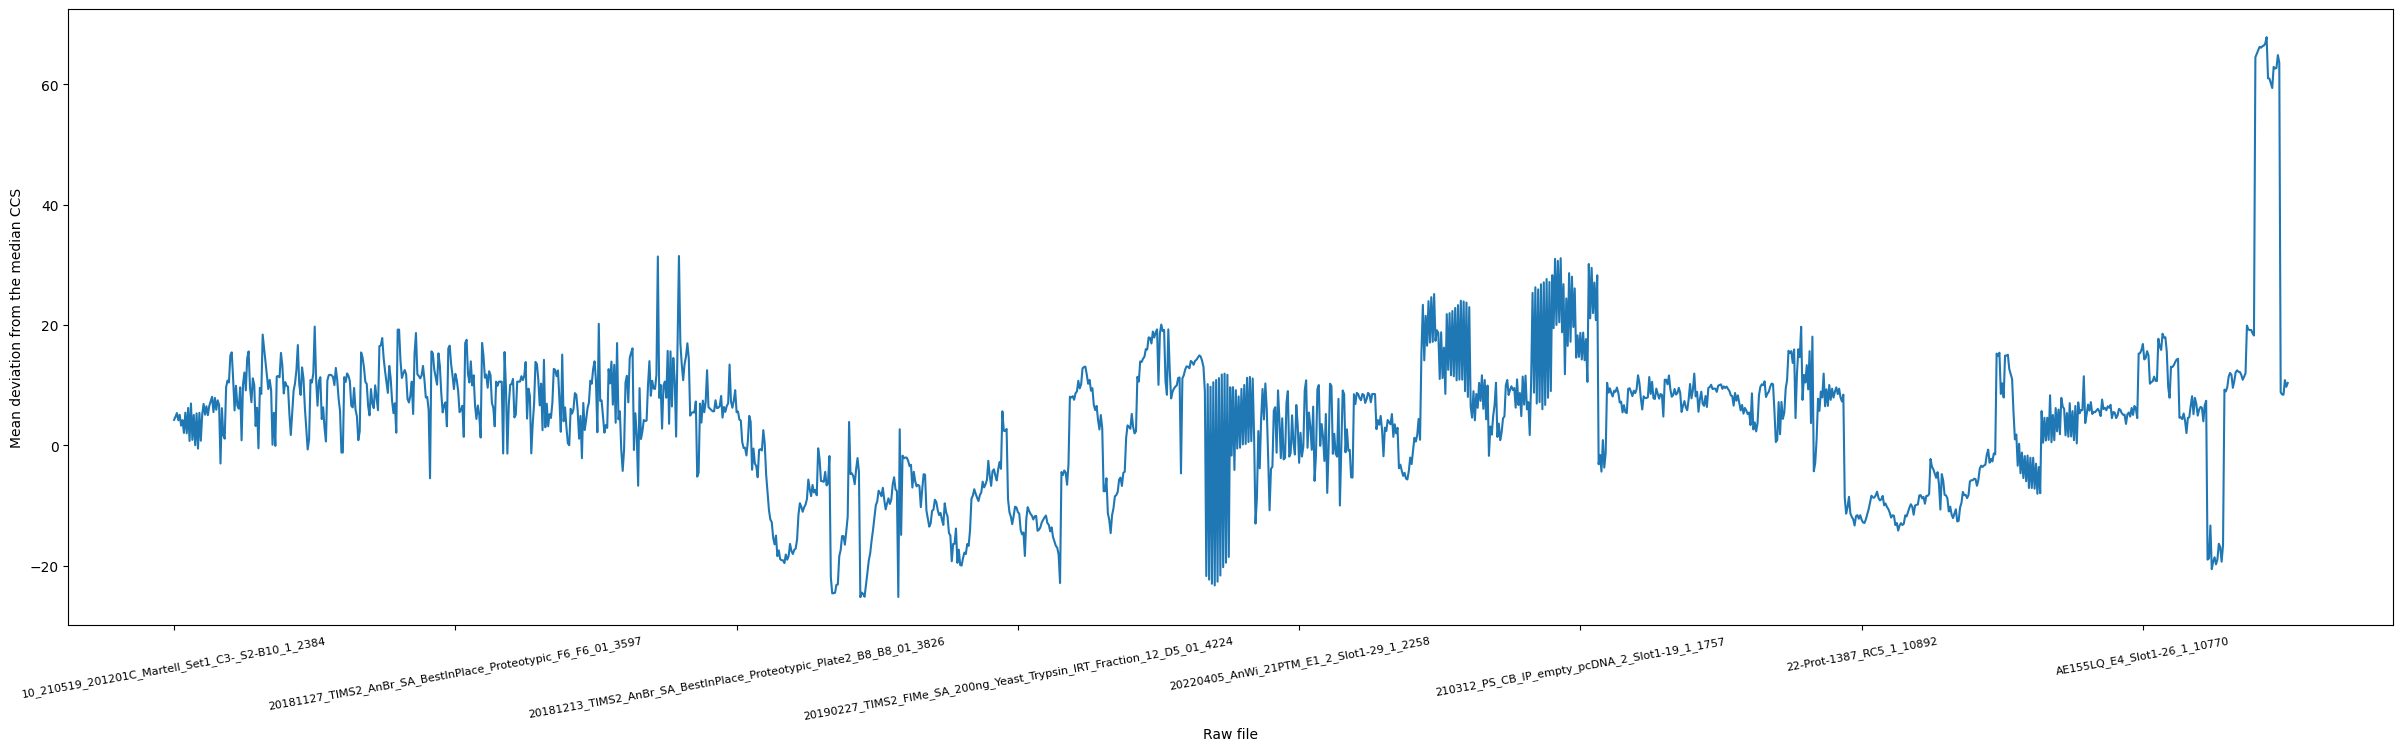

In [46]:
# Calculate deviation from mean to use as correction factors

evidence_pivot_deviation = evidence_pivot_long.subtract(evidence_pivot_tmp.iloc[:, -1], axis = 0)
evidence_pivot_deviation.mean(axis = 0, skipna = True).plot(figsize = (30,8))

plt.xlabel('Raw file')
plt.ylabel('Mean deviation from the median CCS')
plt.xticks(size=8, rotation=10)

In [47]:
# Subtract run correction factor from each peptide CCS value in each run
evidence_pivot_aligned = evidence_pivot_long.subtract(evidence_pivot_deviation.mean(axis = 0, skipna = True), axis = 1)

In [48]:
# Export aligned dataset
evidence_pivot_aligned.to_csv('MQ_alignment_output_6.csv', index=False)
print('Aligned pivot dataset exported.')

Aligned pivot dataset exported.


### Whole-proteome digests

In [49]:
evidence_pivot_aligned = pd.read_csv('MQ_alignment_output_6.csv')

In [50]:
# Calculate mean CCS value from aligned data

evidence_short_aligned = evidence_pivot_aligned.drop(columns = evidence_pivot_aligned.columns.tolist())
evidence_short_aligned['CCS'] = evidence_pivot_aligned.mean(axis = 1, skipna = True)
evidence_short_aligned.reset_index(inplace = True)
evidence_short_aligned = evidence_short_aligned.dropna()

In [51]:
evidence_all

,Sequence,Length,Modifications,Modified sequence,Oxidation (M) Probabilities,Oxidation (M) Score Diffs,Acetyl (Protein N-term),Oxidation (M),Missed cleavages,Proteins,...,Reporter intensity 3,Reporter intensity 4,Reporter intensity 5,Reporter intensity count 1,Reporter intensity count 2,Reporter intensity count 3,Reporter intensity count 4,Reporter intensity count 5,Reporter PIF,Reporter fraction
0,AAAAAAAAAAAAAAGAAGK,19,Unmodified,_AAAAAAAAAAAAAAGAAGK_,NaN,NaN,0.0,0,0.0,E9PTX9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAAAAAAAAAAAAAGAAGK,19,Unmodified,NaN,NaN,NaN,0.0,0,0.0,E9PTX9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAAAAAAAAAAAAAGAAGK,19,Unmodified,NaN,NaN,NaN,0.0,0,0.0,E9PTX9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAAAAAAAAAAAAAGAAGK,19,Unmodified,NaN,NaN,NaN,0.0,0,0.0,E9PTX9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAAAAAAAAAAAAAGAAGK,19,Unmodified,NaN,NaN,NaN,0.0,0,0.0,E9PTX9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15307351,YYVTIIDAPGHR,12,Unmodified,_YYVTIIDAPGHR_,NaN,NaN,0.0,0,0.0,P68104;Q5VTE0,...,1105.8,1969.1,2129.5,1.0,1.0,1.0,1.0,1.0,NaN,NaN
15307352,YYVTIIDAPGHR,12,Unmodified,_YYVTIIDAPGHR_,NaN,NaN,0.0,0,0.0,P68104;Q5VTE0,...,7991.0,6093.2,2935.1,1.0,1.0,1.0,1.0,1.0,NaN,NaN
15307353,YYVTIIDAPGHR,12,Unmodified,_YYVTIIDAPGHR_,NaN,NaN,0.0,0,0.0,P68104;Q5VTE0,...,5330.7,5028.0,4001.6,1.0,1.0,1.0,1.0,1.0,NaN,NaN
15307354,YYVTIIDAPGHR,12,Unmodified,_YYVTIIDAPGHR_,NaN,NaN,0.0,0,0.0,P68104;Q5VTE0,...,1270.5,1826.0,1451.3,1.0,1.0,1.0,1.0,1.0,NaN,NaN


In [52]:
# # Select evidences

# group = ['CElegans_Tryp',
#  'Drosophila_LysC',
#  'Drosophila_LysN',
#  'Drosophila_Trp',
#  'Ecoli_LysC',
#  'Ecoli_LysN',
#  'Ecoli_trypsin',
#  'HeLa_LysC',
#  'HeLa_LysN',
#  'HeLa_Trp_2',
#  'HeLa_Trypsin_1',
#  'Yeast_LysC',
#  'Yeast_LysN',
#  'Yeast_Trypsin']    

# evidence_tmp = evidence_all.loc[evidence_all['Experiment'].isin(group)]

evidence_tmp = evidence_all.copy()
len(evidence_tmp)

15230708

In [53]:
# Select evidence columns of interest
selection = ['Modified sequence', 'Sequence', 'Charge', 'Mass', 'm/z', 'Experiment', 'id', 
             'Intensity', 'Score', 'Length', 'Retention time']
evidence_unique = evidence_tmp.loc[evidence_tmp.groupby(['Modified sequence', 'Charge'])['Intensity'].idxmax()][selection]

In [54]:
evidence_unique.head()

,Modified sequence,Sequence,Charge,Mass,m/z,Experiment,id,Intensity,Score,Length,Retention time
8551215,_(Acetyl (Protein N-term))AAAAAAAAAAGAAGGR_,AAAAAAAAAAGAAGGR,2,1239.63200,620.823275,Meso125F_NE3_1,82,1033600.0,147.780,16,63.731
13266373,_(Acetyl (Protein N-term))AAAAAAAAAAGDSDSWDADT...,AAAAAAAAAAGDSDSWDADTFSMEDPVRK,3,2909.27738,970.766403,d3_D_2,59,721220.0,125.770,29,129.390
13266353,_(Acetyl (Protein N-term))AAAAAAAAAAGDSDSWDADT...,AAAAAAAAAAGDSDSWDADTFSMEDPVR,2,2781.18242,1391.598480,d7_B_1,39,240120.0,80.049,28,146.750
13266349,_(Acetyl (Protein N-term))AAAAAAAAAAGDSDSWDADT...,AAAAAAAAAAGDSDSWDADTFSMEDPVR,3,2781.18242,928.068082,d3_D_1,35,142160.0,78.673,28,146.880
3996111,_(Acetyl (Protein N-term))AAAAAAAAAAM(Oxidatio...,AAAAAAAAAAMTAAGGGGAGAAR,2,1814.86934,908.441948,41_210519_210316A_Martell_Set2_CCL4_7-_S2-E5_1...,69,18595.0,146.370,23,32.857


In [55]:
len(evidence_short_aligned['CCS']), len(evidence_unique)

(1148760, 1148760)

In [56]:
evidence_unique.head()

,Modified sequence,Sequence,Charge,Mass,m/z,Experiment,id,Intensity,Score,Length,Retention time
8551215,_(Acetyl (Protein N-term))AAAAAAAAAAGAAGGR_,AAAAAAAAAAGAAGGR,2,1239.63200,620.823275,Meso125F_NE3_1,82,1033600.0,147.780,16,63.731
13266373,_(Acetyl (Protein N-term))AAAAAAAAAAGDSDSWDADT...,AAAAAAAAAAGDSDSWDADTFSMEDPVRK,3,2909.27738,970.766403,d3_D_2,59,721220.0,125.770,29,129.390
13266353,_(Acetyl (Protein N-term))AAAAAAAAAAGDSDSWDADT...,AAAAAAAAAAGDSDSWDADTFSMEDPVR,2,2781.18242,1391.598480,d7_B_1,39,240120.0,80.049,28,146.750
13266349,_(Acetyl (Protein N-term))AAAAAAAAAAGDSDSWDADT...,AAAAAAAAAAGDSDSWDADTFSMEDPVR,3,2781.18242,928.068082,d3_D_1,35,142160.0,78.673,28,146.880
3996111,_(Acetyl (Protein N-term))AAAAAAAAAAM(Oxidatio...,AAAAAAAAAAMTAAGGGGAGAAR,2,1814.86934,908.441948,41_210519_210316A_Martell_Set2_CCL4_7-_S2-E5_1...,69,18595.0,146.370,23,32.857


In [57]:
evidence_unique['CCS'] = evidence_short_aligned['CCS'].values
evidence_unique.head()

,Modified sequence,Sequence,Charge,Mass,m/z,Experiment,id,Intensity,Score,Length,Retention time,CCS
8551215,_(Acetyl (Protein N-term))AAAAAAAAAAGAAGGR_,AAAAAAAAAAGAAGGR,2,1239.63200,620.823275,Meso125F_NE3_1,82,1033600.0,147.780,16,63.731,409.181586
13266373,_(Acetyl (Protein N-term))AAAAAAAAAAGDSDSWDADT...,AAAAAAAAAAGDSDSWDADTFSMEDPVRK,3,2909.27738,970.766403,d3_D_2,59,721220.0,125.770,29,129.390,675.752631
13266353,_(Acetyl (Protein N-term))AAAAAAAAAAGDSDSWDADT...,AAAAAAAAAAGDSDSWDADTFSMEDPVR,2,2781.18242,1391.598480,d7_B_1,39,240120.0,80.049,28,146.750,593.085242
13266349,_(Acetyl (Protein N-term))AAAAAAAAAAGDSDSWDADT...,AAAAAAAAAAGDSDSWDADTFSMEDPVR,3,2781.18242,928.068082,d3_D_1,35,142160.0,78.673,28,146.880,682.043900
3996111,_(Acetyl (Protein N-term))AAAAAAAAAAM(Oxidatio...,AAAAAAAAAAMTAAGGGGAGAAR,2,1814.86934,908.441948,41_210519_210316A_Martell_Set2_CCL4_7-_S2-E5_1...,69,18595.0,146.370,23,32.857,492.912110


In [60]:
import os

# Create directory if it doesn't exist
if not os.path.exists('MQ_alignment_output'):
    os.makedirs('MQ_alignment_output')

# Export aligned dataset for deep learning
evidence_unique.to_csv('MQ_alignment_output/evidence_aligned_6.csv', index=False)
print('Aligned dataset exported.')

Aligned dataset exported.


In [61]:
evidence_unique['precursor'] = evidence_unique['Modified sequence'] + evidence_unique['Charge'].astype(str)
evidence_unique['precursor'].is_unique

True

In [62]:
evidence_unique

,Modified sequence,Sequence,Charge,Mass,m/z,Experiment,id,Intensity,Score,Length,Retention time,CCS,precursor
8551215,_(Acetyl (Protein N-term))AAAAAAAAAAGAAGGR_,AAAAAAAAAAGAAGGR,2,1239.63200,620.823275,Meso125F_NE3_1,82,1033600.0,147.780,16,63.731,409.181586,_(Acetyl (Protein N-term))AAAAAAAAAAGAAGGR_2
13266373,_(Acetyl (Protein N-term))AAAAAAAAAAGDSDSWDADT...,AAAAAAAAAAGDSDSWDADTFSMEDPVRK,3,2909.27738,970.766403,d3_D_2,59,721220.0,125.770,29,129.390,675.752631,_(Acetyl (Protein N-term))AAAAAAAAAAGDSDSWDADT...
13266353,_(Acetyl (Protein N-term))AAAAAAAAAAGDSDSWDADT...,AAAAAAAAAAGDSDSWDADTFSMEDPVR,2,2781.18242,1391.598480,d7_B_1,39,240120.0,80.049,28,146.750,593.085242,_(Acetyl (Protein N-term))AAAAAAAAAAGDSDSWDADT...
13266349,_(Acetyl (Protein N-term))AAAAAAAAAAGDSDSWDADT...,AAAAAAAAAAGDSDSWDADTFSMEDPVR,3,2781.18242,928.068082,d3_D_1,35,142160.0,78.673,28,146.880,682.043900,_(Acetyl (Protein N-term))AAAAAAAAAAGDSDSWDADT...
3996111,_(Acetyl (Protein N-term))AAAAAAAAAAM(Oxidatio...,AAAAAAAAAAMTAAGGGGAGAAR,2,1814.86934,908.441948,41_210519_210316A_Martell_Set2_CCL4_7-_S2-E5_1...,69,18595.0,146.370,23,32.857,492.912110,_(Acetyl (Protein N-term))AAAAAAAAAAM(Oxidatio...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5320646,_YYYVQNVYTPVDEHVYPDHR_,YYYVQNVYTPVDEHVYPDHR,4,2556.17099,640.050023,Proteotypic_2_A12,161170,33682.0,61.042,20,26.381,694.075700,_YYYVQNVYTPVDEHVYPDHR_4
15016455,_YYYWAVNPQDR_,YYYWAVNPQDR,2,1473.66771,737.841133,DMSO_2,249788,44534.0,48.157,11,44.291,410.046330,_YYYWAVNPQDR_2
8537301,_YYYWVINPADSSGITPK_,YYYWVINPADSSGITPK,2,1972.95708,987.485816,OS_R_2W_1,382779,28359.0,36.460,17,69.349,479.643863,_YYYWVINPADSSGITPK_2
14254359,_YYYYNM(Oxidation (M))ELNK_,YYYYNMELNK,2,1415.60675,708.810653,GYF_1_6200,104034,24004.0,56.378,10,20.201,396.787100,_YYYYNM(Oxidation (M))ELNK_2


In [63]:
import re 
def remove_content_in_brackets(input_string):
    pattern = re.compile(r'\([^)]*\)')  # Match anything between ( and ) including the opening bracket
    result = re.sub(pattern, '', input_string)
    result = result.replace(")", "")
    return result
def parse_seq(seq):
    seq = seq.strip("_")
    seq = seq.replace('(ox)', '(Oxidation (M))')
    seq = seq.replace('(de)', '(Deamidation)')
    seq = seq.replace('(ac)', '(Acetyl (Protein N-term))')
    # First find all 'C' occurrences
    no_brackets = remove_content_in_brackets(seq)
    c_positions = [i+1 for i, char in enumerate(no_brackets) if char=="C"]
    result = [f"{i}|Carbamidomethyl" for i in c_positions]
    current_index = 0 # Keeps track of the last found opening bracket
    pattern = re.compile(r'\((.*?)\)')  # Match anything inside parentheses
    match = pattern.search(seq)
    while match:
        start = match.start()
        name = match.group(1)
        end = match.end()
        result.append(f"{start + current_index}|{name.split(' ')[0]}")
        # Remove the first part from the string and update the position of the 
        # last found opening bracket
        seq = seq[end+1:]
        current_index += match.start()
        match = pattern.search(seq)
    result.sort(key=lambda x: int(x.split("|")[0]))
    return "|".join(result)

In [64]:
evidence_unique['modifications'] = evidence_unique['Modified sequence'].apply(parse_seq)
evidence_unique['modifications'] = evidence_unique['modifications'].replace('','Not modified')

In [65]:
evidence_unique

,Modified sequence,Sequence,Charge,Mass,m/z,Experiment,id,Intensity,Score,Length,Retention time,CCS,precursor,modifications
8551215,_(Acetyl (Protein N-term))AAAAAAAAAAGAAGGR_,AAAAAAAAAAGAAGGR,2,1239.63200,620.823275,Meso125F_NE3_1,82,1033600.0,147.780,16,63.731,409.181586,_(Acetyl (Protein N-term))AAAAAAAAAAGAAGGR_2,0|Acetyl
13266373,_(Acetyl (Protein N-term))AAAAAAAAAAGDSDSWDADT...,AAAAAAAAAAGDSDSWDADTFSMEDPVRK,3,2909.27738,970.766403,d3_D_2,59,721220.0,125.770,29,129.390,675.752631,_(Acetyl (Protein N-term))AAAAAAAAAAGDSDSWDADT...,0|Acetyl
13266353,_(Acetyl (Protein N-term))AAAAAAAAAAGDSDSWDADT...,AAAAAAAAAAGDSDSWDADTFSMEDPVR,2,2781.18242,1391.598480,d7_B_1,39,240120.0,80.049,28,146.750,593.085242,_(Acetyl (Protein N-term))AAAAAAAAAAGDSDSWDADT...,0|Acetyl
13266349,_(Acetyl (Protein N-term))AAAAAAAAAAGDSDSWDADT...,AAAAAAAAAAGDSDSWDADTFSMEDPVR,3,2781.18242,928.068082,d3_D_1,35,142160.0,78.673,28,146.880,682.043900,_(Acetyl (Protein N-term))AAAAAAAAAAGDSDSWDADT...,0|Acetyl
3996111,_(Acetyl (Protein N-term))AAAAAAAAAAM(Oxidatio...,AAAAAAAAAAMTAAGGGGAGAAR,2,1814.86934,908.441948,41_210519_210316A_Martell_Set2_CCL4_7-_S2-E5_1...,69,18595.0,146.370,23,32.857,492.912110,_(Acetyl (Protein N-term))AAAAAAAAAAM(Oxidatio...,0|Acetyl|11|Oxidation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5320646,_YYYVQNVYTPVDEHVYPDHR_,YYYVQNVYTPVDEHVYPDHR,4,2556.17099,640.050023,Proteotypic_2_A12,161170,33682.0,61.042,20,26.381,694.075700,_YYYVQNVYTPVDEHVYPDHR_4,Not modified
15016455,_YYYWAVNPQDR_,YYYWAVNPQDR,2,1473.66771,737.841133,DMSO_2,249788,44534.0,48.157,11,44.291,410.046330,_YYYWAVNPQDR_2,Not modified
8537301,_YYYWVINPADSSGITPK_,YYYWVINPADSSGITPK,2,1972.95708,987.485816,OS_R_2W_1,382779,28359.0,36.460,17,69.349,479.643863,_YYYWVINPADSSGITPK_2,Not modified
14254359,_YYYYNM(Oxidation (M))ELNK_,YYYYNMELNK,2,1415.60675,708.810653,GYF_1_6200,104034,24004.0,56.378,10,20.201,396.787100,_YYYYNM(Oxidation (M))ELNK_2,6|Oxidation


In [66]:
peprec = pd.DataFrame()
peprec['sequence'] = evidence_unique['Sequence']
peprec['modifications'] = evidence_unique['modifications']
peprec['charge'] = evidence_unique['Charge']
peprec['tr'] = evidence_unique['CCS']

In [67]:
peprec.to_csv('output/MQpeprec.csv')